In [2]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

## Image Augmentation

In [3]:
url = "dataset-out"

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   rescale=1./255,
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 64
img_size = (128, 128)

train_set = train_datagen.flow_from_directory(url + '/train', 
                                              class_mode='sparse',
                                              batch_size = batch_size,
                                              target_size=img_size,)

val_set = test_datagen.flow_from_directory(url + '/val',
                                           class_mode='sparse',
                                           batch_size = batch_size,
                                           target_size=img_size,)

test_set = test_datagen.flow_from_directory(url + '/test',
                                            class_mode='sparse',
                                           batch_size = batch_size,
                                           shuffle=False,
                                           target_size=img_size)

Found 2019 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
Found 257 images belonging to 6 classes.


In [4]:
class_to_index = train_set.class_indices
index_to_class = {v: k for k, v in class_to_index.items()}

print(class_to_index)
print(index_to_class)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


## Base Model

In [5]:
model1 = keras.models.Sequential([
    keras.layers.Input(shape=(128,128,3)),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(6, activation='softmax'),
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        3

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=2)
checkpoint = keras.callbacks.ModelCheckpoint('my_model', save_best_only=True)

hist = model1.fit(train_set, validation_data=val_set, epochs=20, callbacks=[early_stopping, checkpoint])

## Transfer Learning with MobileNetV2

In [6]:
baseModel = keras.applications.MobileNetV2(input_shape=(128, 128, 3), weights='imagenet',
                                           include_top=False)

for layers in baseModel.layers:
    layers.trainable=False

In [7]:
model = keras.models.Sequential([
    baseModel,
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(6, activation='softmax'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=50
callbacks = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dropout_3 (Dropout)         (None, 20480)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                1310784   
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                      

In [8]:
history = model.fit(train_set, validation_data=val_set, epochs=epochs, callbacks=[callbacks])

Epoch 1/50
32/32 [==============================] - 23s 623ms/step - loss: 1.6355 - accuracy: 0.4175 - val_loss: 1.0445 - val_accuracy: 0.6135
Epoch 2/50
32/32 [==============================] - 18s 545ms/step - loss: 1.1118 - accuracy: 0.5820 - val_loss: 0.8687 - val_accuracy: 0.7012
Epoch 3/50
32/32 [==============================] - 18s 563ms/step - loss: 1.0299 - accuracy: 0.6285 - val_loss: 0.7839 - val_accuracy: 0.7012
Epoch 4/50
32/32 [==============================] - 18s 560ms/step - loss: 0.9426 - accuracy: 0.6607 - val_loss: 0.7475 - val_accuracy: 0.7490
Epoch 5/50
32/32 [==============================] - 18s 552ms/step - loss: 0.9046 - accuracy: 0.6840 - val_loss: 0.7824 - val_accuracy: 0.7689
Epoch 6/50
32/32 [==============================] - 17s 543ms/step - loss: 0.8488 - accuracy: 0.6929 - val_loss: 0.7301 - val_accuracy: 0.7928
Epoch 7/50
32/32 [==============================] - 17s 535ms/step - loss: 0.8021 - accuracy: 0.7093 - val_loss: 0.7876 - val_accuracy: 0.7729

#### Save model

In [9]:
model.save("waste_classifier_v2")

INFO:tensorflow:Assets written to: waste_classifier_v2\assets


INFO:tensorflow:Assets written to: waste_classifier_v2\assets


#### Training process evaluating

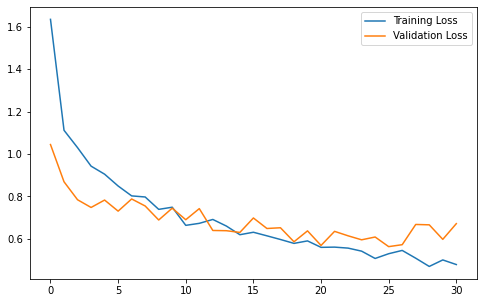

In [10]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])

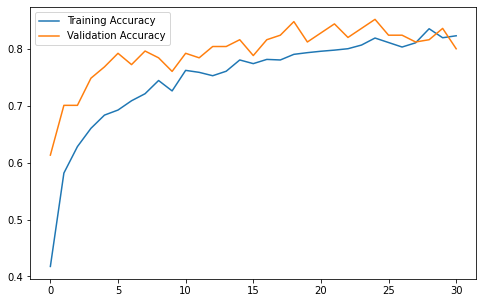

In [11]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])

## Validation Test

In [12]:
train_set = test_datagen.flow_from_directory(url + '/train',
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            target_size=img_size)

validation_set = test_datagen.flow_from_directory(url + '/test',
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            target_size=img_size)

Found 2019 images belonging to 6 classes.
Found 257 images belonging to 6 classes.


### Train Loss vs Validation Loss

In [13]:
print("Training loss - Accuracy")
model.evaluate(train_set)
print("Validation loss - Accuracy")
model.evaluate(val_set)
print()

Training loss - Accuracy
32/32 [==============================] - 12s 356ms/step - loss: 0.2552 - accuracy: 0.9104
Validation loss - Accuracy
4/4 [==============================] - 2s 378ms/step - loss: 0.5626 - accuracy: 0.8247



### Precision, Recall, F1-score, and Confusion Matrix

In [14]:
target_names = list(test_set.class_indices.keys())

def evaluate(y, y_pred):
    fig, ax = plt.subplots(figsize=(10, 10))

    cm = confusion_matrix(y, y_pred, normalize='all')

    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    cmp.plot(ax=ax, cmap='Blues')
    fig.show()

    print(classification_report(y, y_pred, digits=5, target_names=target_names))

#### Train set

32/32 [==============================] - 13s 394ms/step
              precision    recall  f1-score   support

   cardboard    0.94277   0.97205   0.95719       322
       glass    0.96471   0.82000   0.88649       400
       metal    0.82908   0.99085   0.90278       328
       paper    0.97511   0.90737   0.94002       475
     plastic    0.85922   0.91948   0.88833       385
       trash    0.86139   0.79817   0.82857       109

    accuracy                        0.91035      2019
   macro avg    0.90538   0.90132   0.90056      2019
weighted avg    0.91593   0.91035   0.91023      2019



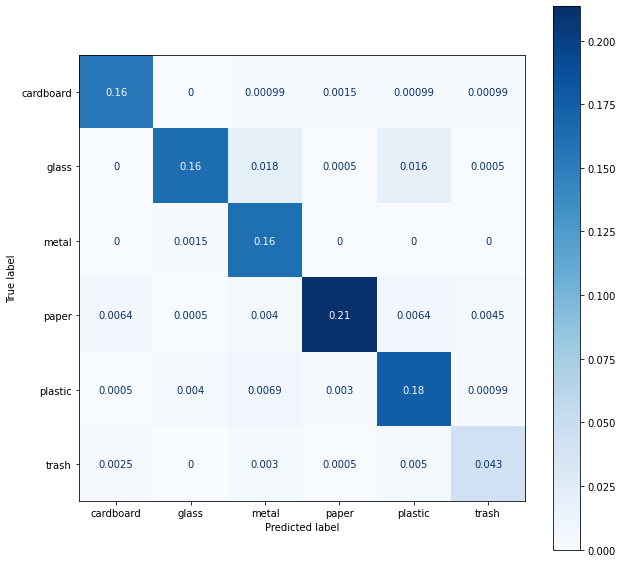

In [15]:
y = train_set.labels
y_pred = np.argmax(model.predict(train_set), axis=1)
evaluate(y, y_pred)

#### Validation set

4/4 [==============================] - 2s 371ms/step
              precision    recall  f1-score   support

   cardboard    0.10870   0.12500   0.11628        40
       glass    0.23404   0.22000   0.22680        50
       metal    0.11905   0.12195   0.12048        41
       paper    0.17308   0.15254   0.16216        59
     plastic    0.13462   0.14583   0.14000        48
       trash    0.00000   0.00000   0.00000        13

    accuracy                        0.14741       251
   macro avg    0.12825   0.12755   0.12762       251
weighted avg    0.14982   0.14741   0.14828       251



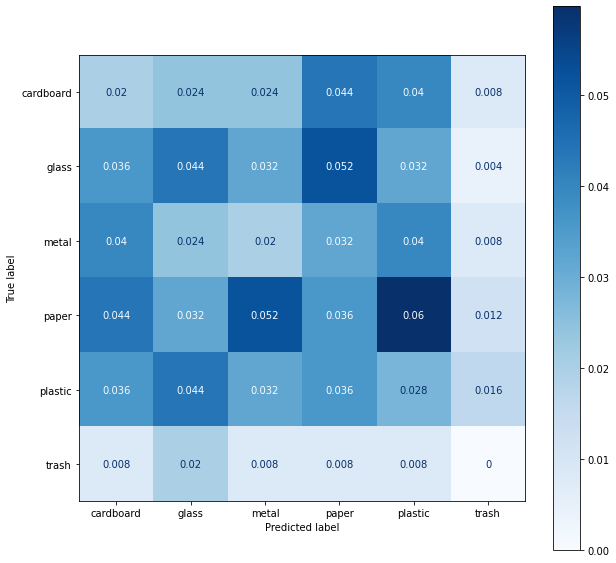

In [16]:
y = val_set.labels
y_pred = np.argmax(model.predict(val_set), axis=1)
evaluate(y, y_pred)

## Final Evaluation on Test set

### Classification Report and Confusion Matrix

5/5 [==============================] - 2s 294ms/step
              precision    recall  f1-score   support

   cardboard    0.83721   0.87805   0.85714        41
       glass    0.82609   0.74510   0.78351        51
       metal    0.78000   0.95122   0.85714        41
       paper    0.80702   0.76667   0.78632        60
     plastic    0.71154   0.75510   0.73267        49
       trash    0.88889   0.53333   0.66667        15

    accuracy                        0.79377       257
   macro avg    0.80846   0.77158   0.78058       257
weighted avg    0.79788   0.79377   0.79115       257



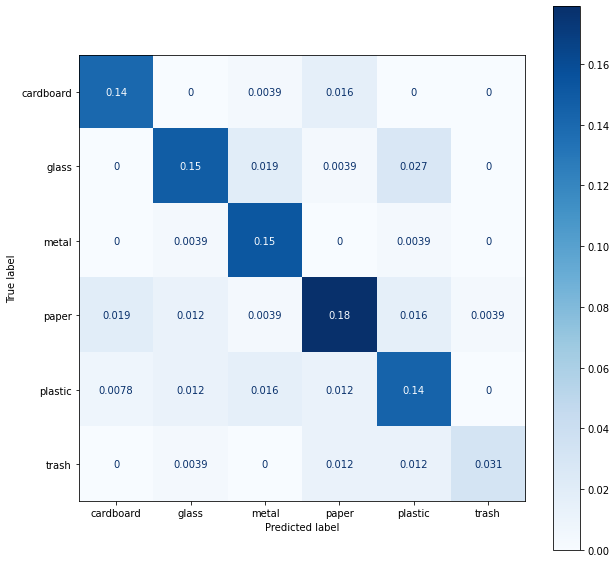

In [17]:
y = test_set.labels
y_pred = np.argmax(model.predict(test_set), axis=1)
evaluate(y, y_pred)

### Random Sample Test

In [18]:
def test():
    batch = np.random.randint(0, len(test_set)-1)
    data = 0
    img = np.random.randint(0, len(test_set[batch][data])-1)
    IMAG = test_set[batch][data][img]

    plt.imshow(IMAG)
    plt.show()
    pred = model.predict(IMAG.reshape(1, 128, 128, 3))
    probability = pred.max()
    index = np.argmax(pred)
    label = index_to_class.get(index)
    print(f"Model predicts {label.capitalize()} with probability {probability}")
    

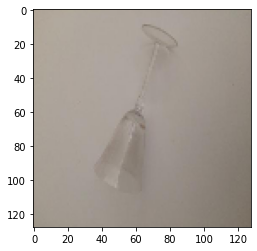

1/1 [==============================] - 1s 742ms/step
Model predicts Plastic with probability 0.5261492133140564


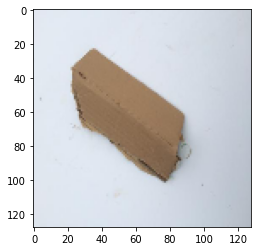

1/1 [==============================] - 0s 33ms/step
Model predicts Cardboard with probability 0.9900522828102112


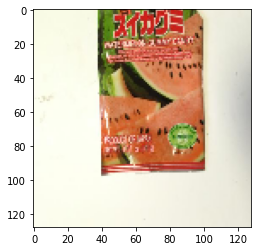

1/1 [==============================] - 0s 31ms/step
Model predicts Paper with probability 0.874748945236206


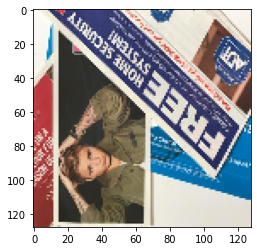

1/1 [==============================] - 0s 30ms/step
Model predicts Paper with probability 0.9997170567512512


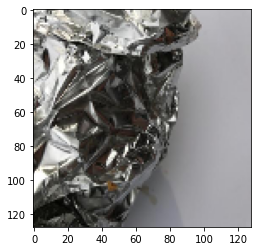

1/1 [==============================] - 0s 30ms/step
Model predicts Plastic with probability 0.44042280316352844


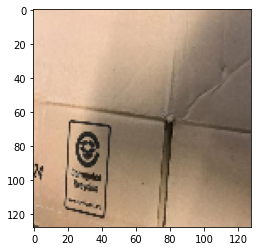

1/1 [==============================] - 0s 35ms/step
Model predicts Cardboard with probability 0.9998200535774231


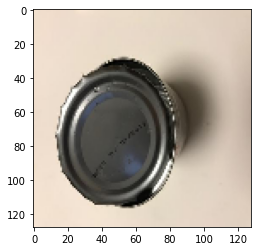

1/1 [==============================] - 0s 31ms/step
Model predicts Metal with probability 0.9927355051040649


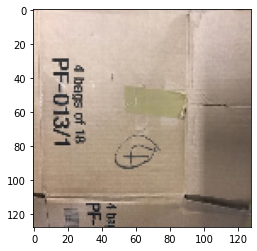

1/1 [==============================] - 0s 31ms/step
Model predicts Cardboard with probability 0.9997894167900085


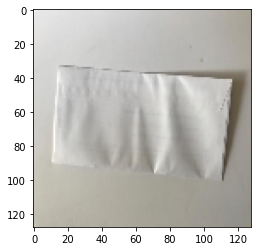

1/1 [==============================] - 0s 29ms/step
Model predicts Paper with probability 0.9953782558441162


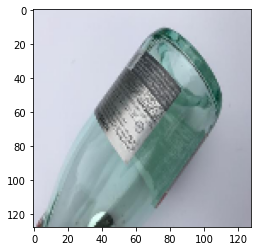

1/1 [==============================] - 0s 31ms/step
Model predicts Glass with probability 0.9474467039108276


In [19]:
for i in range(10):
    test()